In [1]:
import pandas as pd
import numpy as np
import shap
import json
import pickle
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
# load dataset
df = pd.read_csv('../../../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [3]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# list of all airport-dependent features to drop
airport_dependent = ['airport_icao', 'runway_designator_number', 'runway_designator_side', 'runway_ils_category']

# define features and targets
X = df.drop(columns=label_columns + airport_dependent)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['weather_phenomenon', 'rvr_tendency'])

In [4]:
y = df[label_columns]

In [5]:
# concat X and y for deduplication
combined = pd.concat([X, y], axis=1)

# drop duplicates
combined_no_dupes = combined.drop_duplicates()

# split back into features and labels
X = combined_no_dupes.drop(columns=label_columns)
y = combined_no_dupes[label_columns]

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

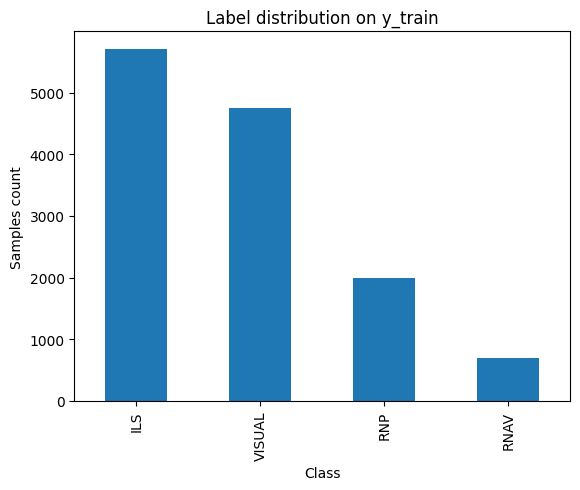

Label distribution:
 ILS       5705
VISUAL    4745
RNP       1992
RNAV       694
dtype: int64


In [7]:
# check for label distribution
label_counts = y_train.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('Label distribution on y_train')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [8]:
# oversampling imbalanced labels
try:
    X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
    print("SMOTE successful. X_train after SMOTE:", X_train_sm.shape)
    print("Label distribution after SMOTE:\n", pd.DataFrame(y_train_sm, columns=label_columns).sum())
    X_train_use, y_train_use = X_train_sm, y_train_sm
except Exception as e:
    print("SMOTE failed for multi-label")
    X_train_use, y_train_use = X_train, y_train

SMOTE failed for multi-label


In [9]:
# build and train multi-label model
base_model = OneVsRestClassifier(XGBClassifier(eval_metric='logloss'))

# hyperparameter tuning
params = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'estimator__max_depth': [3, 5, 7, 10],
    'estimator__subsample': [0.7, 0.8, 0.9, 1.0],
    'estimator__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'estimator__gamma': [0, 1, 2, 3, 4, 5],
    'estimator__reg_alpha': [0, 0.5, 1],
    'estimator__reg_lambda': [0, 0.5, 1],
    'estimator__min_child_weight': [1, 2, 3, 4, 5],
    'estimator__scale_pos_weight': [1, 10, 20, 30, 40],
    'estimator__max_delta_step': [0, 1, 5, 10],
}

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=params,
    n_iter=500,
    cv=5,
    scoring='f1_macro',
    verbose=10,
    n_jobs=8,
    random_state=42
)

# build and train multi-label model
search.fit(X_train, y_train)

# pick the best model
model = search.best_estimator_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


In [10]:
print(search.best_params_)

{'estimator__subsample': 0.9, 'estimator__scale_pos_weight': 10, 'estimator__reg_lambda': 1, 'estimator__reg_alpha': 1, 'estimator__n_estimators': 100, 'estimator__min_child_weight': 1, 'estimator__max_depth': 10, 'estimator__max_delta_step': 10, 'estimator__learning_rate': 0.3, 'estimator__gamma': 0, 'estimator__colsample_bytree': 1.0}


In [11]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__scale_pos_weight,param_estimator__reg_lambda,param_estimator__reg_alpha,param_estimator__n_estimators,param_estimator__min_child_weight,...,param_estimator__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
34,3.033895,0.191947,0.100259,0.003971,0.9,10,1.0,1.0,100,1,...,1.0,"{'estimator__subsample': 0.9, 'estimator__scal...",0.790507,0.787953,0.804203,0.801613,0.809602,0.798776,0.008249,1
360,2.968867,0.334689,0.113652,0.007299,1.0,30,0.0,0.5,200,2,...,1.0,"{'estimator__subsample': 1.0, 'estimator__scal...",0.782527,0.794342,0.803180,0.800513,0.803996,0.796912,0.007949,2
300,4.235737,0.066650,0.166858,0.002740,1.0,10,1.0,0.5,300,4,...,0.8,"{'estimator__subsample': 1.0, 'estimator__scal...",0.787299,0.796858,0.806565,0.787197,0.803809,0.796346,0.008074,3
143,4.983825,0.070722,0.153434,0.004964,1.0,40,0.0,0.5,300,1,...,0.9,"{'estimator__subsample': 1.0, 'estimator__scal...",0.787018,0.788732,0.794701,0.796533,0.804283,0.794253,0.006146,4
238,5.602750,0.084729,0.173110,0.004876,0.8,20,0.5,0.0,300,4,...,0.8,"{'estimator__subsample': 0.8, 'estimator__scal...",0.778493,0.799624,0.797111,0.792098,0.802783,0.794022,0.008515,5


In [12]:
# save trained model
with open("../../trained_models/model-xgb-ovr-RS-no_airport_feats.pkl", "wb") as f:
    pickle.dump(model, f)

In [13]:
# features in order
feature_order = list(X.columns)

# save to json
with open("../../feature_order/feature_order_xgb_ovr_RS_no_airport_feats.json", "w") as f:
    json.dump(feature_order, f)

In [14]:
# predict and evaluate
y_pred = model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 3 out of 2247
      visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
4144        10.0          11         18             100  6000.0      -5.5   
5190        10.0          12         20             270  6000.0      11.8   
3671        10.0           6          0             210  6000.0       1.0   

      crosswind  ceiling  weather_phenomenon_+RA  weather_phenomenon_+RA BR  \
4144       -9.5    12000                   False                      False   
5190        2.1     9000                   False                      False   
3671        5.9    99999                   False                      False   

      ...  weather_phenomenon_RA  weather_phenomenon_RA BR  \
4144  ...                  False                     False   
5190  ...                  False                     False   
3671  ...                  False                     False   

      weather_phenomenon_TS  weather_phenomenon_TS BR  \
4144                

C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


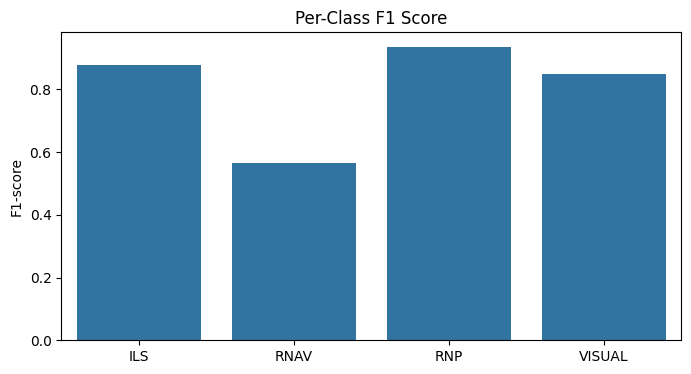

In [15]:
# per-class F1-score bar chart
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_columns))]
plt.figure(figsize=(8,4))
sns.barplot(x=label_columns, y=f1_scores)
plt.title("Per-Class F1 Score")
plt.ylabel("F1-score")
plt.show()

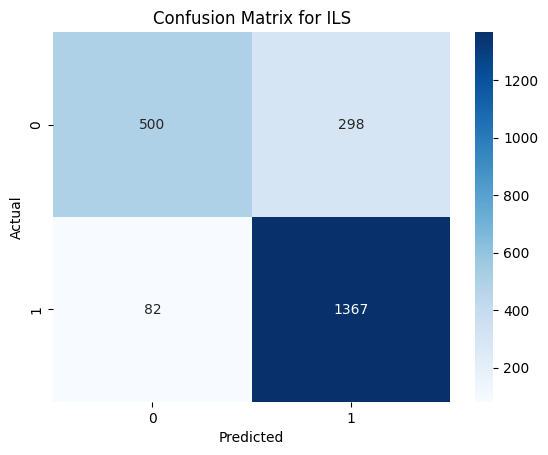

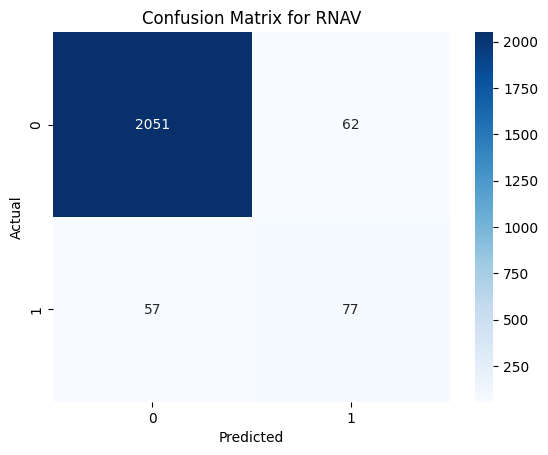

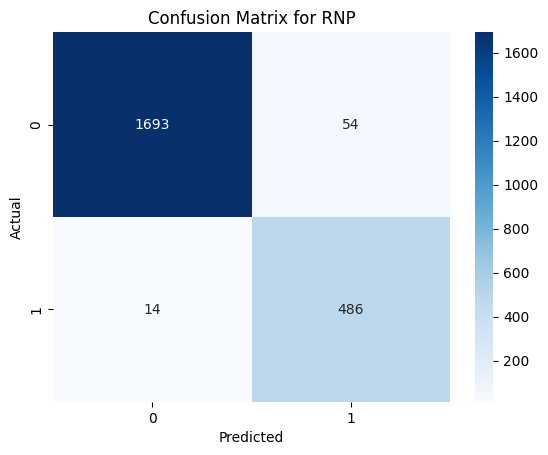

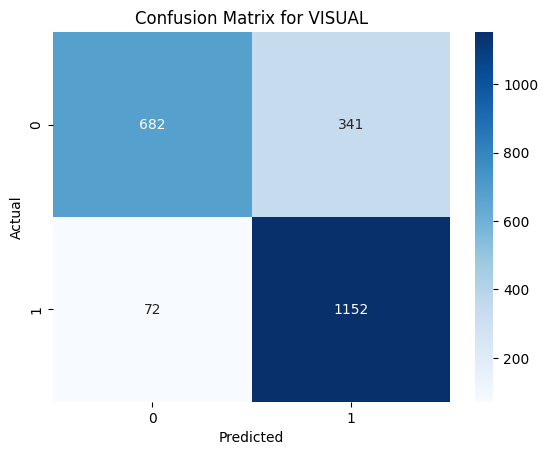

In [16]:
# confusion matrix per label
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(label_columns):
    plt.figure()
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"../../visualizations/confusion-matrix/no_airport_features-OVR/{label}-no_airport_features-ovr-RS.png")
    plt.show()

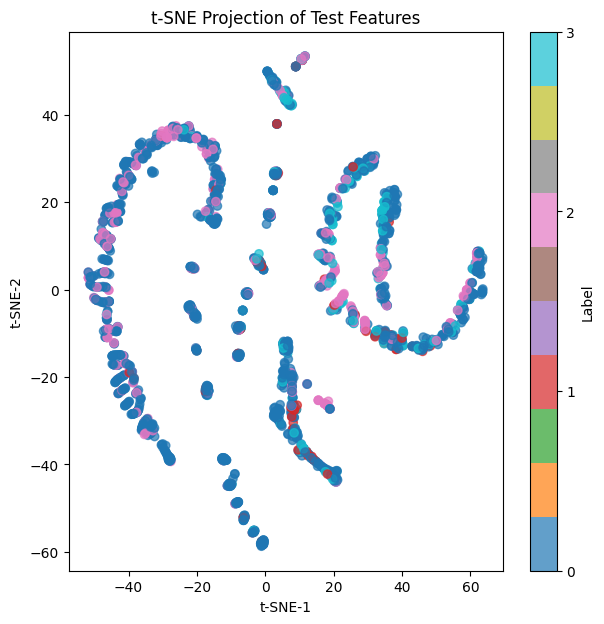

In [17]:
# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_proj = tsne.fit_transform(X_test)
dominant_label = np.argmax(y_test.values, axis=1)
plt.figure(figsize=(7,7))
plt.scatter(X_proj[:,0], X_proj[:,1], c=dominant_label, cmap='tab10', alpha=0.7)
plt.title('t-SNE Projection of Test Features')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.colorbar(ticks=range(len(label_columns)), label='Label')
plt.savefig("../../visualizations/t-SNE/no_airport_features-ovr-RS.png")
plt.show()

SHAP summary plot for ILS


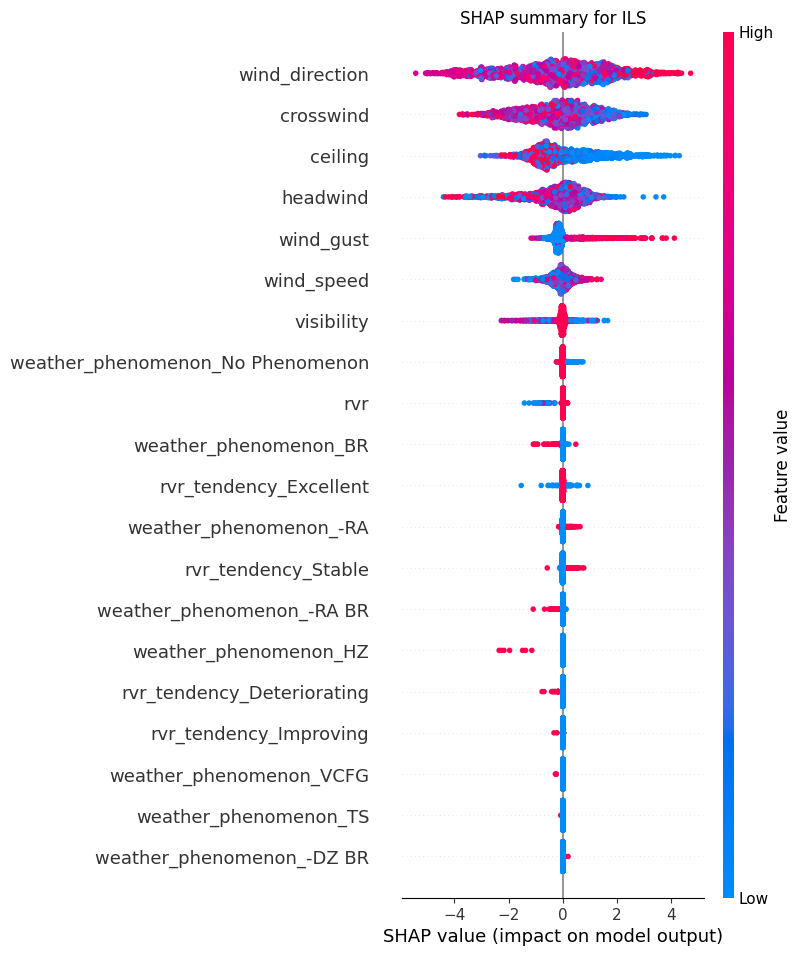

SHAP summary plot for RNAV


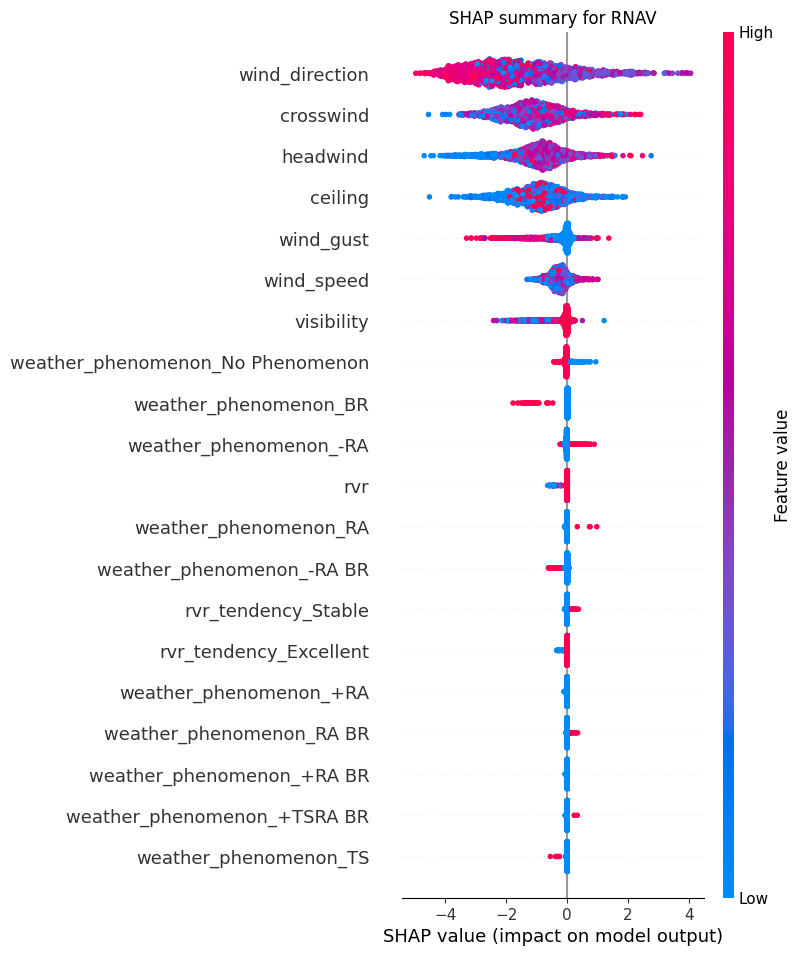

SHAP summary plot for RNP


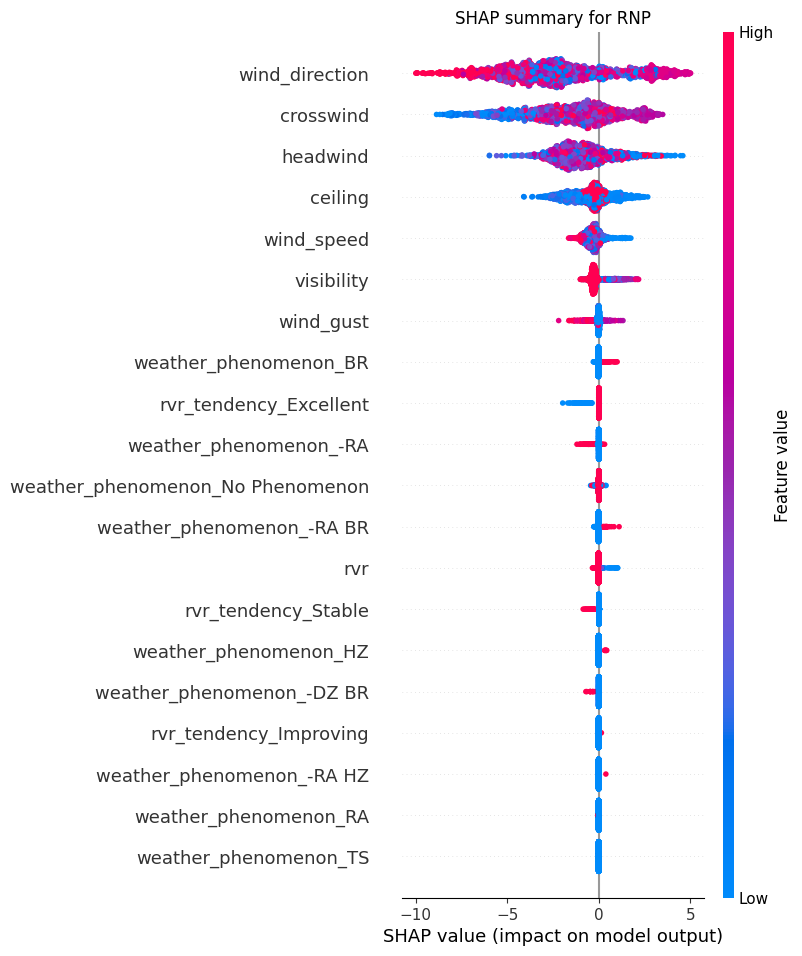

SHAP summary plot for VISUAL


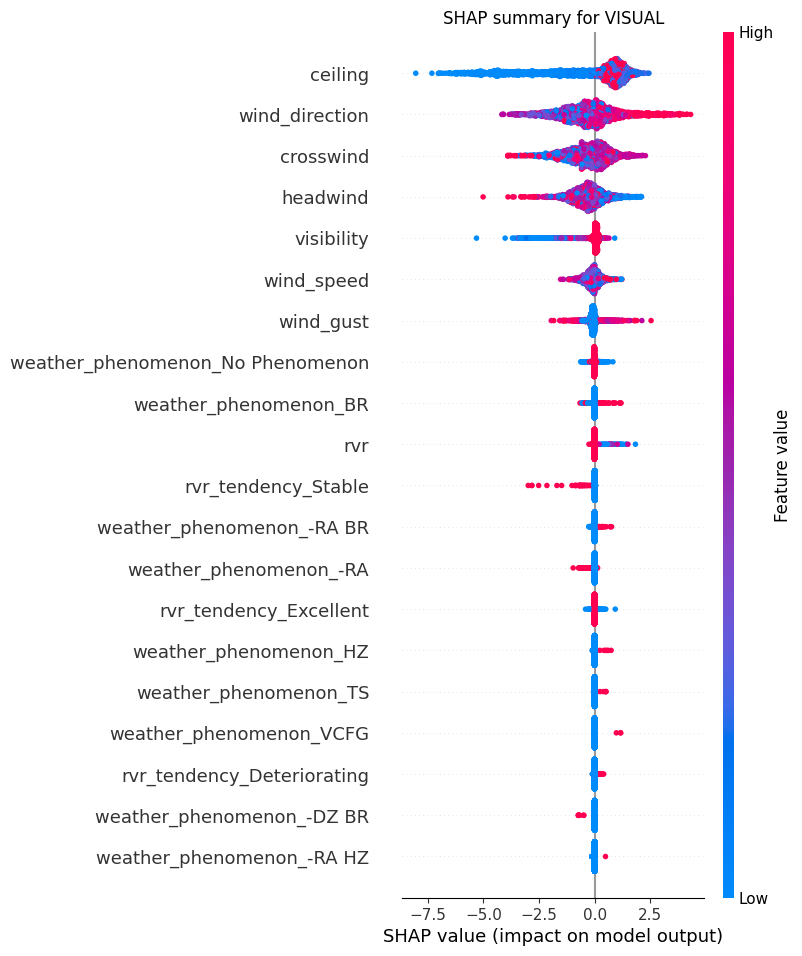

In [18]:
# SHAP summary plot per label
for idx, label in enumerate(label_columns):
    print(f"SHAP summary plot for {label}")
    explainer = shap.TreeExplainer(model.estimators_[idx])
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP summary for {label}")
    plt.savefig(f"../../visualizations/SHAP/no_airport_features-OVR/{label}-no_airport_features-ovr-RS.png")
    plt.show()

In [19]:
# false predictions cases
for i, label in enumerate(label_columns):
    false_positives = np.where((y_test[label].values == 0) & (y_pred[:, i] == 1))[0]
    false_negatives = np.where((y_test[label].values == 1) & (y_pred[:, i] == 0))[0]
    print(f"\n{label} False Positives (max 5):")
    display(X_test.iloc[false_positives[:5]])
    print(f"{label} False Negatives (max 5):")
    display(X_test.iloc[false_negatives[:5]])


ILS False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
3349,10.0,3,0,280,6000.0,2.6,1.5,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
15773,10.0,4,0,250,6000.0,3.5,-2.0,7500,False,False,...,False,False,False,False,False,False,False,True,False,False
12447,10.0,6,0,180,6000.0,1.0,-5.9,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
3759,10.0,7,0,90,6000.0,6.1,3.5,3200,False,False,...,False,False,False,False,False,False,False,True,False,False
5975,10.0,13,22,190,6000.0,4.4,-12.2,25000,False,False,...,False,False,False,False,False,False,False,True,False,False


ILS False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
1946,10.0,8,0,200,6000.0,4.0,-6.9,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
18671,10.0,4,0,110,6000.0,-3.9,-0.7,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
168,10.0,3,0,240,6000.0,3.0,-0.5,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
20384,10.0,16,0,260,6000.0,15.8,2.8,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
13303,10.0,7,0,290,6000.0,6.1,3.5,99999,False,False,...,False,False,False,False,False,False,False,True,False,False



RNAV False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
16805,10.0,3,0,250,6000.0,-1.5,-2.6,25000,False,False,...,False,False,False,False,False,False,False,True,False,False
154,10.0,6,0,330,6000.0,4.6,-3.9,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
11510,10.0,13,0,200,6000.0,12.2,-4.4,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
2617,10.0,6,0,240,6000.0,-3.9,-4.6,7500,False,False,...,False,False,False,False,False,False,False,True,False,False
16319,10.0,11,0,180,6000.0,1.9,10.8,25000,False,False,...,False,False,False,False,False,False,False,True,False,False


RNAV False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
4144,10.0,11,18,100,6000.0,-5.5,-9.5,12000,False,False,...,False,False,False,False,False,False,False,True,False,False
7167,6.0,13,24,160,6000.0,6.5,-11.3,2600,False,False,...,False,False,False,False,False,False,False,True,False,False
20027,1.5,9,0,70,6000.0,8.9,-1.6,700,False,False,...,False,False,False,False,False,False,False,True,False,False
3718,10.0,12,0,190,6000.0,10.4,-6.0,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
18434,10.0,6,0,30,6000.0,2.1,-5.6,99999,False,False,...,False,False,False,False,False,False,False,True,False,False



RNP False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
1946,10.0,8,0,200,6000.0,4.0,-6.9,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
8662,3.0,3,0,100,6000.0,-3.0,0.0,200,False,False,...,False,False,False,False,False,False,False,True,False,False
7901,10.0,5,0,30,6000.0,-3.2,3.8,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
9377,10.0,3,0,110,6000.0,-2.6,-1.5,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
1692,10.0,10,0,110,6000.0,8.7,5.0,3300,False,False,...,False,False,False,False,False,False,False,True,False,False


RNP False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
3349,10.0,3,0,280,6000.0,2.6,1.5,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
3828,10.0,7,0,60,6000.0,6.9,-1.2,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
8627,10.0,4,0,200,6000.0,3.1,-2.6,10000,False,False,...,False,False,False,False,False,False,False,True,False,False
18446,10.0,0,0,0,6000.0,-0.0,0.0,4000,False,False,...,False,False,False,False,False,False,False,True,False,False
9674,10.0,6,0,-1,6000.0,-2.9,5.2,99999,False,False,...,False,False,False,False,False,False,False,True,False,False



VISUAL False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
2156,10.0,17,0,240,6000.0,16.7,-3.0,1600,False,False,...,False,False,False,False,False,False,False,True,False,False
4444,10.0,7,0,120,6000.0,-6.6,-2.4,10000,False,False,...,False,False,False,False,False,False,False,True,False,False
1946,10.0,8,0,200,6000.0,4.0,-6.9,99999,False,False,...,False,False,False,False,False,False,False,True,False,False
3962,10.0,11,0,40,6000.0,11.0,0.0,8500,False,False,...,False,False,False,False,False,False,False,True,False,False
18671,10.0,4,0,110,6000.0,-3.9,-0.7,99999,False,False,...,False,False,False,False,False,False,False,True,False,False


VISUAL False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_RA,weather_phenomenon_RA BR,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable
3759,10.0,7,0,90,6000.0,6.1,3.5,3200,False,False,...,False,False,False,False,False,False,False,True,False,False
17164,10.0,17,21,200,6000.0,8.5,-14.7,20000,False,False,...,False,False,False,False,False,False,False,True,False,False
17426,10.0,12,0,230,6000.0,7.7,-9.2,1500,False,False,...,False,False,False,False,False,False,False,True,False,False
15232,10.0,5,0,340,6000.0,-0.9,4.9,1500,False,False,...,False,False,False,False,False,False,False,True,False,False
17468,10.0,18,0,250,6000.0,15.6,-9.0,1500,False,False,...,False,False,False,False,False,False,False,True,False,False
